# Preprocessing and clustering 3k PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).

We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.

The data consist of *3k PBMCs from a Healthy Donor* and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.

In [32]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: data: File exists
zsh:1: command not found: wget
mkdir: write: File exists


In [12]:
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: write: File exists


:::{note}
Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.
:::

:::{note}
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.
:::

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# So many little things that go into setting up the environment
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.3 scipy==1.10.1 pandas==2.0.2 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.4 pynndescent==0.5.10


/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/umap/umap_.py:660: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [3]:
# This is the HDF5 file that will store the adata from the analysis
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [4]:
# Assuming there are a variety of functions for reading different file formats
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


:::{note}
See [anndata-tutorials/getting-started](https://anndata-tutorials.readthedocs.io/en/latest/getting-started.html) for a more comprehensive introduction to `AnnData`.
:::

In [5]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

## Preprocessing

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


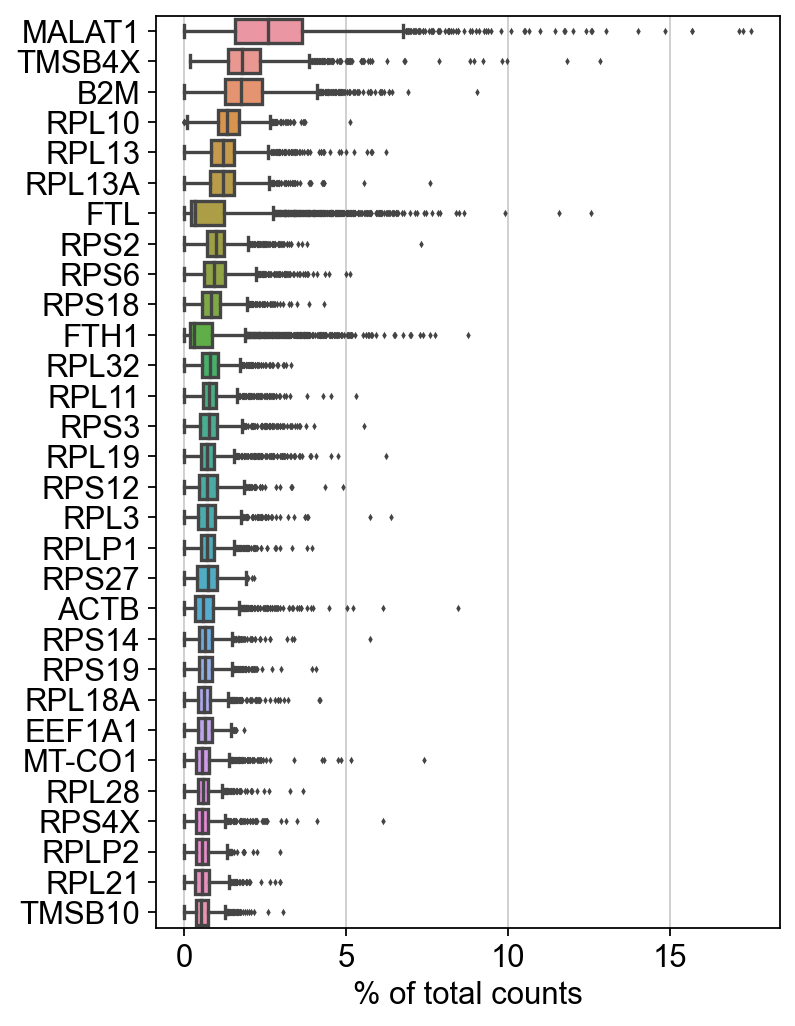

In [8]:
# Is this just percentage of total counts - I guess thats the basic definition for highest expressed genes
# MALAT1 is a lncRNA that is highly expressed in many cell types - doesn't do anything, but its seen everywhere
sc.pl.highest_expr_genes(adata, n_top=30, )

Basic filtering:

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Let's assemble some information about mitochondrial genes, which are important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [15]:
# Note how simple the var and obs are - there isn't all that much information in them - however, n_genes and n_cells have been added as they are relevant to obs and var
# from the filter_cells and filter_genes procedures
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [16]:
# var['mt] is simply an array of True/False values depending on whether the gene starts with MT-
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [17]:
adata # Note new var/obs are added with preprocessing

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

A violin plot of some of the computed quality measures:

* the number of genes expressed in the count matrix
* the total counts per cell
* the percentage of counts in mitochondrial genes

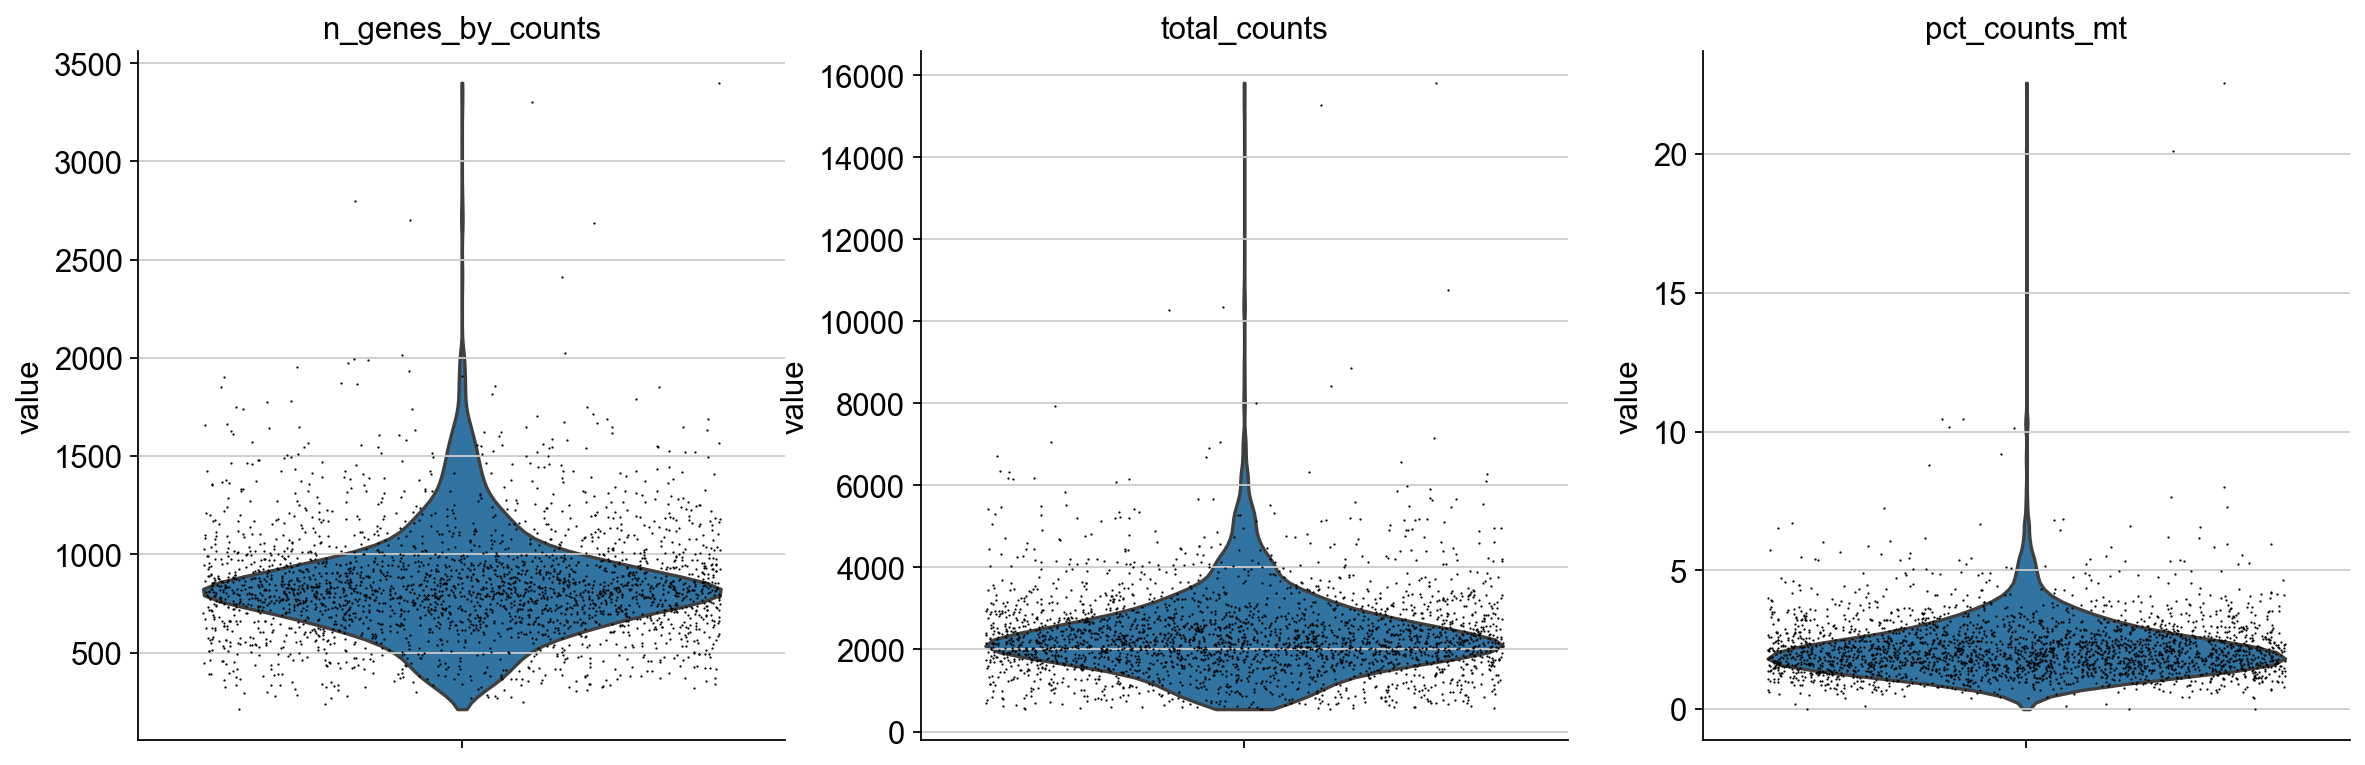

In [20]:
# Looking at some of the quality control metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts:

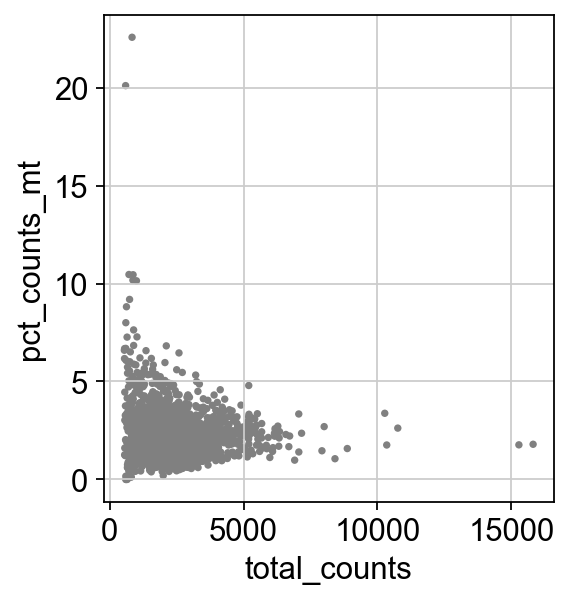

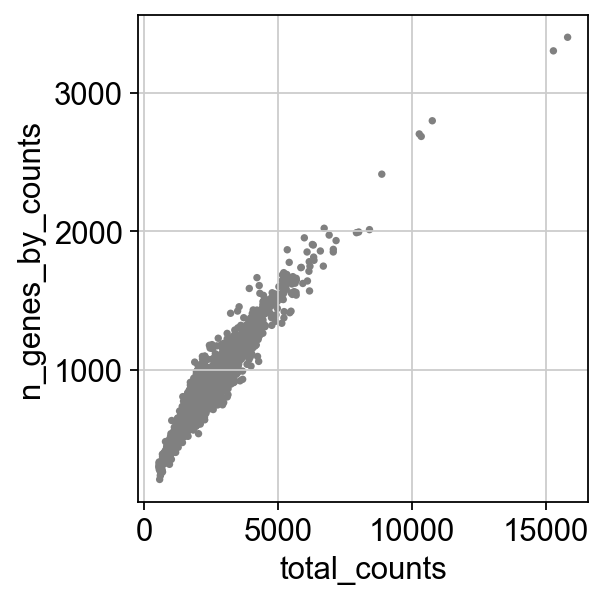

In [21]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# Graph makes sense as the total counts increase, the number of distinct genes will also tend to increase
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Actually do the filtering by slicing the `AnnData` object.

In [22]:
# When slicing and then assigning, it creates a copy - actually changes the original adata
# Keep cells that have less than 2500 distinct genes and less than 5% mitochondrial genes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [23]:
# Factoring the total counts to 10,000 - this is a common normalization procedure
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell


    finished (0:00:00)


/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [24]:
adata # Note that n_obs has decreased from 2700 to 2638

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Logarithmize the data:

In [25]:
# Log scale it - log1p is log(1+x) - this is a common transformation, making sure log(0) doesn't occur
sc.pp.log1p(adata)

Identify highly-variable genes.

In [26]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) # Threshold for dispersion - if passes level of dispersion, qualifies as highly variable

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [27]:
adata # So many new variables added to the var - highly variable genes, means, dispersions, etc.

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [31]:
# Keeps track of parameters for normalization including log and then also calculating highly variable genes using seurat
adata.uns

OrderedDict([('log1p', {'base': None}), ('hvg', {'flavor': 'seurat'})])

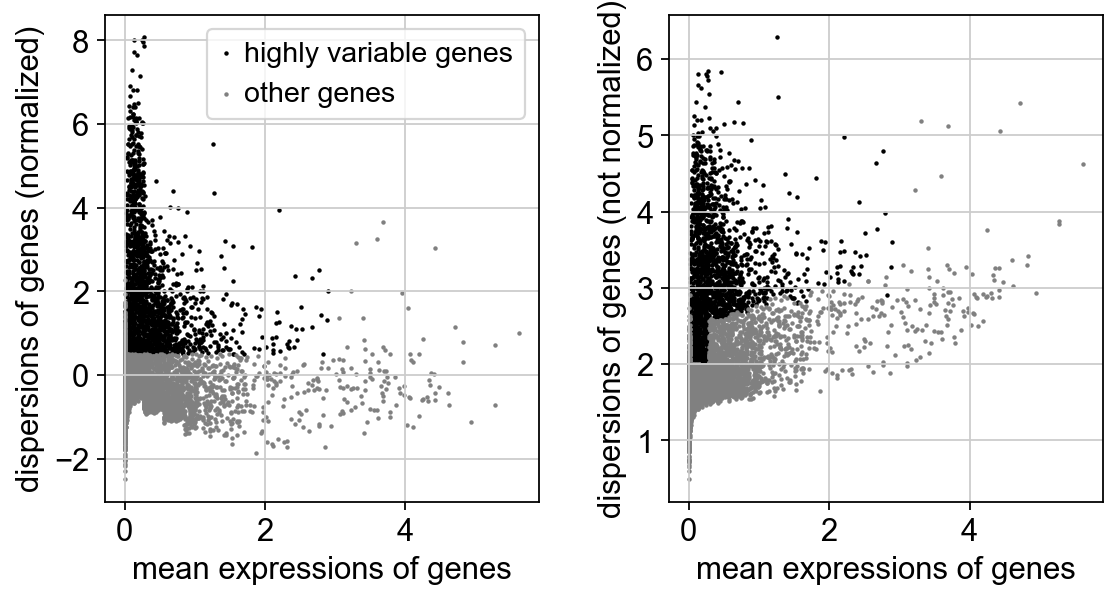

In [32]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.

:::{note}
You can get back an `AnnData` of the object in `.raw` by calling `.raw.to_adata()`.
:::

In [33]:
# Wonder why you need to do this - could just use non raw data - well I guess if you want to store away this level of data (could just use layers though)
adata.raw = adata

:::{note}
If you don't proceed below with correcting the data with `sc.pp.regress_out` and scaling it via `sc.pp.scale`, you can also get away without using `.raw` at all.

The result of the previous highly-variable-genes detection is stored as an annotation in `.var.highly_variable` and auto-detected by PCA and hence, `sc.pp.neighbors` and subsequent manifold/graph tools. In that case, the step *actually do the filtering* below is unnecessary, too.
:::

In [19]:
# Not needed  - can skip safely
adata = adata[:, adata.var.highly_variable]

In [35]:
adata.to_df()

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  \
AAACATACAACCAC-1         0.0         0.0            0.0            0.0   
AAACATTGAGCTAC-1         0.0         0.0            0.0            0.0   
AAACATTGATCAGC-1         0.0         0.0            0.0            0.0   
AAACCGTGCTTCCG-1         0.0         0.0            0.0            0.0   
AAACCGTGTATGCG-1         0.0         0.0            0.0            0.0   
...                      ...         ...            ...            ...   
TTTCGAACTCTCAT-1         0.0         0.0            0.0            0.0   
TTTCTACTGAGGCA-1         0.0         0.0            0.0            0.0   
TTTCTACTTCCTCG-1         0.0         0.0            0.0            0.0   
TTTGCATGAGAGGC-1         0.0         0.0            0.0            0.0   
TTTGCATGCCTCAC-1         0.0         0.0            0.0            0.0   

                  LINC00115  NOC2L  KLHL17  PLEKHN1  RP11-54O7.17  HES4  ...  \
AAACATACAACCAC-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
AAACATTGAGCTAC-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
AAACATTGATCAGC-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
AAACCGTGCTTCCG-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
AAACCGTGTATGCG-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
...                     ...    ...     ...      ...           ...   ...  ...   
TTTCGAACTCTCAT-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
TTTCTACTGAGGCA-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
TTTCTACTTCCTCG-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
TTTGCATGAGAGGC-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   
TTTGCATGCCTCAC-1        0.0    0.0     0.0      0.0           0.0   0.0  ...   

                   MT-ND4L    MT-ND4    MT-ND5  MT-ND6    MT-CYB  AC145212.1  \
AAACATACAACCAC-1  0.000000  3.745718  1.635873     0.0  2.864242         0.0   
AAACATTGAGCTAC-1  0.000000  4.223994  1.111715     0.0  2.851662         0.0   
AAACATTGATCAGC-1  0.000000  2.354503  1.995416     0.0  2.618163         0.0   
AAACCGTGCTTCCG-1  1.566387  2.515108  2.149274     0.0  2.149274         0.0   
AAACCGTGTATGCG-1  0.000000  0.000000  3.063772     0.0  2.416278         0.0   
...                    ...       ...       ...     ...       ...         ...   
TTTCGAACTCTCAT-1  0.000000  1.358668  0.000000     0.0  1.358668         0.0   
TTTCTACTGAGGCA-1  1.362115  1.918229  1.362115     0.0  2.535106         0.0   
TTTCTACTTCCTCG-1  0.000000  3.751096  0.000000     0.0  3.208946         0.0   
TTTGCATGAGAGGC-1  2.378132  0.000000  0.000000     0.0  2.378132         0.0   
TTTGCATGCCTCAC-1  0.000000  1.798457  0.000000     0.0  2.780121         0.0   

                  AL592183.1  AL354822.1  PNRC2-1  SRSF10-1  
AAACATACAACCAC-1    0.000000    0.000000      0.0       0.0  
AAACATTGAGCTAC-1    1.111715    0.000000      0.0       0.0  
AAACATTGATCAGC-1    0.000000    0.000000      0.0       0.0  
AAACCGTGCTTCCG-1    0.000000    0.000000      0.0       0.0  
AAACCGTGTATGCG-1    0.000000    0.000000      0.0       0.0  
...                      ...         ...      ...       ...  
TTTCGAACTCTCAT-1    0.000000    0.000000      0.0       0.0  
TTTCTACTGAGGCA-1    0.000000    0.000000      0.0       0.0  
TTTCTACTTCCTCG-1    0.000000    0.000000      0.0       0.0  
TTTGCATGAGAGGC-1    0.000000    2.378132      0.0       0.0  
TTTGCATGCCTCAC-1    0.000000    0.000000      0.0       0.0  

[2638 rows x 13714 columns]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [36]:
# Remove sources of variation that are not biological - total counts and percent mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:00)


In [37]:
# I wonder how the negative numbers work - what does it mean to have a negative number of normalized, log transformed counts?
adata.to_df()

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  \
AAACATACAACCAC-1   -0.006122   -0.001480      -0.002136      -0.002923   
AAACATTGAGCTAC-1   -0.009402   -0.001555      -0.010525      -0.011048   
AAACATTGATCAGC-1   -0.005427   -0.002481      -0.005944      -0.001574   
AAACCGTGCTTCCG-1   -0.005468   -0.002045      -0.003649      -0.001515   
AAACCGTGTATGCG-1   -0.003277   -0.001995       0.001954       0.003911   
...                      ...         ...            ...            ...   
TTTCGAACTCTCAT-1   -0.006629   -0.002023      -0.006354      -0.004374   
TTTCTACTGAGGCA-1   -0.005781   -0.002512      -0.006973      -0.002459   
TTTCTACTTCCTCG-1   -0.004736   -0.001704       0.000007       0.000417   
TTTGCATGAGAGGC-1   -0.003907   -0.001657       0.002280       0.002480   
TTTGCATGCCTCAC-1   -0.004088   -0.002330      -0.001856       0.001786   

                  LINC00115     NOC2L    KLHL17   PLEKHN1  RP11-54O7.17  \
AAACATACAACCAC-1  -0.011153 -0.159005 -0.001372 -0.003986     -0.002046   
AAACATTGAGCTAC-1  -0.015658 -0.223471 -0.003411 -0.001214     -0.006185   
AAACATTGATCAGC-1  -0.012173 -0.183980 -0.010783 -0.004656     -0.002269   
AAACCGTGCTTCCG-1  -0.011380 -0.168183 -0.006579 -0.004586     -0.001848   
AAACCGTGTATGCG-1  -0.008371 -0.125129 -0.005219 -0.006437      0.000916   
...                     ...       ...       ...       ...           ...   
TTTCGAACTCTCAT-1  -0.012882 -0.189177 -0.006836 -0.003601     -0.003261   
TTTCTACTGAGGCA-1  -0.012703 -0.191798 -0.011223 -0.004359     -0.002740   
TTTCTACTTCCTCG-1  -0.009744 -0.141456 -0.002980 -0.005178     -0.000573   
TTTGCATGAGAGGC-1  -0.008552 -0.124110 -0.002195 -0.005876      0.000503   
TTTGCATGCCTCAC-1  -0.010099 -0.153074 -0.008781 -0.005777     -0.000449   

                      HES4  ...   MT-ND4L    MT-ND4    MT-ND5    MT-ND6  \
AAACATACAACCAC-1 -0.127524  ... -0.264543  0.472208  0.360761 -0.171168   
AAACATTGAGCTAC-1 -0.385848  ... -0.358966  0.424949 -0.774185 -0.290258   
AAACATTGATCAGC-1 -0.113560  ... -0.254997  0.013356  1.217258 -0.161507   
AAACCGTGCTTCCG-1 -0.099259  ...  1.314709 -0.185331  1.205599 -0.156299   
AAACCGTGTATGCG-1  0.073286  ... -0.188609 -2.349242  2.528155 -0.076753   
...                    ...  ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1 -0.188770  ... -0.284606 -1.566565 -1.177229 -0.197716   
TTTCTACTGAGGCA-1 -0.142334  ...  1.096701 -0.461206  0.526317 -0.174699   
TTTCTACTTCCTCG-1 -0.028585  ... -0.227265  0.905705 -0.924758 -0.124747   
TTTGCATGAGAGGC-1  0.037808  ...  2.175014 -2.735039 -0.780463 -0.094228   
TTTGCATGCCTCAC-1 -0.003272  ... -0.215213 -0.425758 -0.572529 -0.111046   

                    MT-CYB  AC145212.1  AL592183.1  AL354822.1   PNRC2-1  \
AAACATACAACCAC-1 -0.231708   -0.012251   -0.191638   -0.004514 -0.064067   
AAACATTGAGCTAC-1 -0.809499   -0.019179    0.927562   -0.011839 -0.109832   
AAACATTGATCAGC-1  0.551910   -0.007827   -0.235975   -0.007025 -0.085630   
AAACCGTGCTTCCG-1 -0.314973   -0.009183   -0.217514   -0.005370 -0.072769   
AAACCGTGTATGCG-1  0.329747   -0.004555   -0.222521   -0.000478 -0.042206   
...                    ...         ...         ...         ...       ...   
TTTCGAACTCTCAT-1 -1.348617   -0.011775   -0.212845   -0.007771 -0.087491   
TTTCTACTGAGGCA-1  0.428278   -0.008508   -0.236125   -0.007906 -0.091266   
TTTCTACTTCCTCG-1  0.580197   -0.008581   -0.205529   -0.002437 -0.052571   
TTTGCATGAGAGGC-1 -0.132670   -0.006911   -0.206252    2.377657 -0.040152   
TTTGCATGCCTCAC-1  0.836425   -0.005350   -0.233949   -0.003552 -0.063235   

                  SRSF10-1  
AAACATACAACCAC-1 -0.037022  
AAACATTGAGCTAC-1 -0.063492  
AAACATTGATCAGC-1 -0.055758  
AAACCGTGCTTCCG-1 -0.045628  
AAACCGTGTATGCG-1 -0.027952  
...                    ...  
TTTCGAACTCTCAT-1 -0.053848  
TTTCTACTGAGGCA-1 -0.059159  
TTTCTACTTCCTCG-1 -0.031945  
TTTGCATGAGAGGC-1 -0.024591  
TTTGCATGCCTCAC-1 -0.042061  

[2638 rows x 13714 columns]

Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [38]:
sc.pp.scale(adata, max_value=10)

In [39]:
# It seems like the values are now number of standard deviations away from the mean?
adata.to_df()

AL627309.1  AP006222.2  RP11-206L10.2  RP11-206L10.9  \
AAACATACAACCAC-1   -0.065470   -0.026908      -0.035932      -0.072358   
AAACATTGAGCTAC-1   -0.100551   -0.028263      -0.177028      -0.273441   
AAACATTGATCAGC-1   -0.058038   -0.045098      -0.099966      -0.038961   
AAACCGTGCTTCCG-1   -0.058474   -0.037176      -0.061365      -0.037507   
AAACCGTGTATGCG-1   -0.035041   -0.036274       0.032865       0.096808   
...                      ...         ...            ...            ...   
TTTCGAACTCTCAT-1   -0.070892   -0.036783      -0.106871      -0.108248   
TTTCTACTGAGGCA-1   -0.061822   -0.045658      -0.117287      -0.060854   
TTTCTACTTCCTCG-1   -0.050644   -0.030972       0.000126       0.010310   
TTTGCATGAGAGGC-1   -0.041779   -0.030125       0.038349       0.061375   
TTTGCATGCCTCAC-1   -0.043718   -0.042349      -0.031209       0.044212   

                  LINC00115     NOC2L    KLHL17   PLEKHN1  RP11-54O7.17  \
AAACATACAACCAC-1  -0.083748 -0.315543 -0.015788 -0.044069     -0.042504   
AAACATTGAGCTAC-1  -0.117581 -0.443474 -0.039259 -0.013426     -0.128465   
AAACATTGATCAGC-1  -0.091409 -0.365104 -0.124096 -0.051474     -0.047124   
AAACCGTGCTTCCG-1  -0.085459 -0.333756 -0.075716 -0.050700     -0.038384   
AAACCGTGTATGCG-1  -0.062862 -0.248317 -0.060059 -0.071169      0.019031   
...                     ...       ...       ...       ...           ...   
TTTCGAACTCTCAT-1  -0.096734 -0.375418 -0.078674 -0.039811     -0.067732   
TTTCTACTGAGGCA-1  -0.095390 -0.380619 -0.129165 -0.048190     -0.056907   
TTTCTACTTCCTCG-1  -0.073171 -0.280718 -0.034295 -0.057247     -0.011907   
TTTGCATGAGAGGC-1  -0.064216 -0.246293 -0.025267 -0.064965      0.010440   
TTTGCATGCCTCAC-1  -0.075836 -0.303773 -0.101051 -0.063873     -0.009323   

                      HES4  ...   MT-ND4L    MT-ND4    MT-ND5    MT-ND6  \
AAACATACAACCAC-1 -0.346804  ... -0.431909  0.644020  0.363650 -0.352814   
AAACATTGAGCTAC-1 -1.049321  ... -0.586068  0.579566 -0.780385 -0.598283   
AAACATTGATCAGC-1 -0.308829  ... -0.416323  0.018215  1.227006 -0.332899   
AAACCGTGCTTCCG-1 -0.269936  ...  2.146471 -0.252763  1.215253 -0.322164   
AAACCGTGTATGCG-1  0.199304  ... -0.307934 -3.204014  2.548400 -0.158204   
...                    ...  ...       ...       ...       ...       ...   
TTTCGAACTCTCAT-1 -0.513363  ... -0.464664 -2.136559 -1.186656 -0.407535   
TTTCTACTGAGGCA-1 -0.387080  ...  1.790538 -0.629016  0.530532 -0.360092   
TTTCTACTTCCTCG-1 -0.077738  ... -0.371046  1.235245 -0.932164 -0.257131   
TTTGCATGAGAGGC-1  0.102819  ...  3.551055 -3.730182 -0.786713 -0.194223   
TTTGCATGCCTCAC-1 -0.008898  ... -0.351369 -0.580669 -0.577114 -0.228889   

                    MT-CYB  AC145212.1  AL592183.1  AL354822.1   PNRC2-1  \
AAACATACAACCAC-1 -0.279304   -0.093459   -0.330107   -0.052484 -0.197500   
AAACATTGAGCTAC-1 -0.975781   -0.146313    1.597773   -0.137665 -0.338576   
AAACATTGATCAGC-1  0.665280   -0.059708   -0.406478   -0.081682 -0.263969   
AAACCGTGCTTCCG-1 -0.379672   -0.070055   -0.374678   -0.062443 -0.224324   
AAACCGTGTATGCG-1  0.397481   -0.034746   -0.383304   -0.005553 -0.130107   
...                    ...         ...         ...         ...       ...   
TTTCGAACTCTCAT-1 -1.625641   -0.089829   -0.366637   -0.090362 -0.269708   
TTTCTACTGAGGCA-1  0.516252   -0.064903   -0.406737   -0.091927 -0.281343   
TTTCTACTTCCTCG-1  0.699377   -0.065463   -0.354034   -0.028342 -0.162060   
TTTGCATGAGAGGC-1 -0.159922   -0.052723   -0.355279   10.000000 -0.123776   
TTTGCATGCCTCAC-1  1.008237   -0.040814   -0.402989   -0.041297 -0.194932   

                  SRSF10-1  
AAACATACAACCAC-1 -0.145338  
AAACATTGAGCTAC-1 -0.249250  
AAACATTGATCAGC-1 -0.218891  
AAACCGTGCTTCCG-1 -0.179123  
AAACCGTGTATGCG-1 -0.109731  
...                    ...  
TTTCGAACTCTCAT-1 -0.211389  
TTTCTACTGAGGCA-1 -0.232238  
TTTCTACTTCCTCG-1 -0.125407  
TTTGCATGAGAGGC-1 -0.096535  
TTTGCATGCCTCAC-1 -0.165117  

[2638 rows x 13714 columns]

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [42]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [43]:
adata # added X_pca to obsmm along with PCs to varm

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [47]:
print(adata.varm['PCs'].shape) # 50 PCs for each gene
adata.varm['PCs']

(13714, 50)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [48]:
print(adata.obsm['X_pca'].shape) # 2638 cells by 50 PCs
adata.obsm['X_pca']

(2638, 50)


array([[-5.5562186 , -0.25772467,  0.1867891 , ..., -0.33665612,
         1.4834467 ,  1.8979387 ],
       [-7.2095175 , -7.4819946 , -0.16268413, ..., -1.9809405 ,
        -1.5541025 , -1.4962773 ],
       [-2.6944354 ,  1.5836648 ,  0.66311795, ...,  0.54309946,
        -0.545685  , -4.339353  ],
       ...,
       [-0.7853941 , -6.718595  , -1.5988172 , ..., -0.56099004,
        -0.10455395,  0.58378303],
       [ 0.281275  , -5.921858  , -1.1628597 , ..., -1.3764969 ,
         3.5824182 ,  1.2991648 ],
       [-0.09076659, -0.6635025 , -0.13485226, ...,  0.37380397,
         0.7490438 , -0.66549337]], dtype=float32)

In [52]:
adata.varm['PCs'][adata.to_df().columns.tolist().index('CST3')] # PC values for CST3

array([ 1.57473728e-01,  1.95802134e-02, -9.88211948e-03, -1.04700970e-02,
       -7.00100651e-03, -1.01483485e-03, -1.71143003e-02,  1.98368374e-02,
       -3.02867778e-02, -7.71606993e-03,  1.12704216e-02,  7.99419545e-03,
        7.26075890e-03, -7.46096624e-03, -3.32790799e-03, -6.43966813e-03,
        3.17067094e-03,  5.65014221e-03,  3.05173104e-04,  1.46219982e-02,
       -4.46800655e-03,  4.82934667e-03,  4.65502823e-03, -1.18817491e-02,
        9.13687516e-03,  7.41619524e-03, -1.16112391e-02,  9.06129181e-03,
        1.48996711e-02,  7.43270712e-03,  4.88049723e-03, -6.40129158e-03,
        1.25344668e-03,  3.66282277e-03,  2.81087239e-04, -5.17133391e-03,
        4.60548047e-03,  1.01239188e-02, -7.95381144e-03, -2.61410496e-05,
        1.12110637e-02, -4.65479819e-03, -1.10035259e-02, -1.11426227e-02,
        2.44817953e-03,  5.53996488e-03, -4.87039937e-03, -5.05272532e-03,
       -9.25717410e-03, -3.08758649e-03])

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

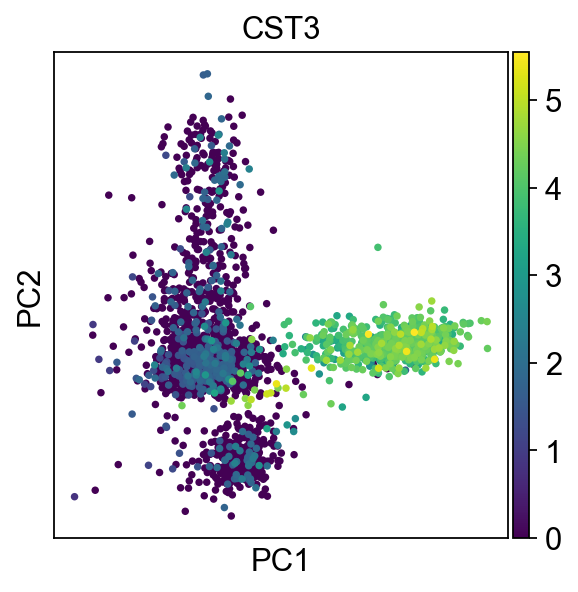

In [49]:
# CST3 refers to a gene - it seems to be colored by frequency of the gene, mapped in a lower dimensional space - why not use UMAP?
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often a rough estimate of the number of PCs does fine.

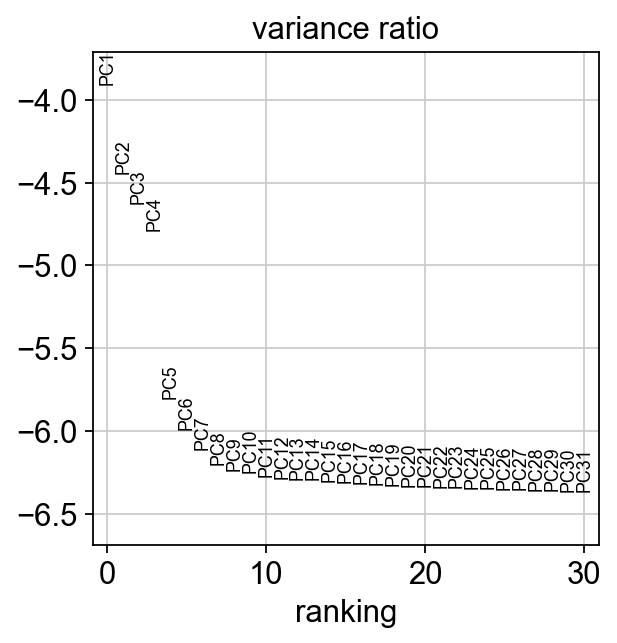

In [53]:
sc.pl.pca_variance_ratio(adata, log=True) # PC1 explains 5% of the variance, PC2 explains 3% of the variance, etc. - ordering which are the most important

Save the result.

In [54]:
adata.write(results_file)

In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [56]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # n_neighbors is the number of neighbors to consider when constructing the graph, n_pcs are number of PCs to use in the computation

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [57]:
adata # obsp refers to pairwise data between observations - so distances/connectivities between cells

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [59]:
adata.obsp['connectivities'] # 2638 x 2638 means each cell has info about all other cells - same for distances

<2638x2638 sparse matrix of type '<class 'numpy.float32'>'
	with 41952 stored elements in Compressed Sparse Row format>

## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```Python
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')
```

In [60]:
sc.tl.umap(adata) # Lower dimensional mapping as usual

computing UMAP


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


In [63]:
print(adata.obsm['X_umap'].shape) # 2638 cells by 2 dimensions of the UMAP
adata.obsm['X_umap']

(2638, 2)


array([[10.454759 ,  2.7326365],
       [ 8.077726 , 10.101445 ],
       [ 7.778509 ,  4.0028086],
       ...,
       [ 5.9919133,  9.933379 ],
       [ 6.029868 , 11.152272 ],
       [ 8.048753 ,  2.9622774]], dtype=float32)

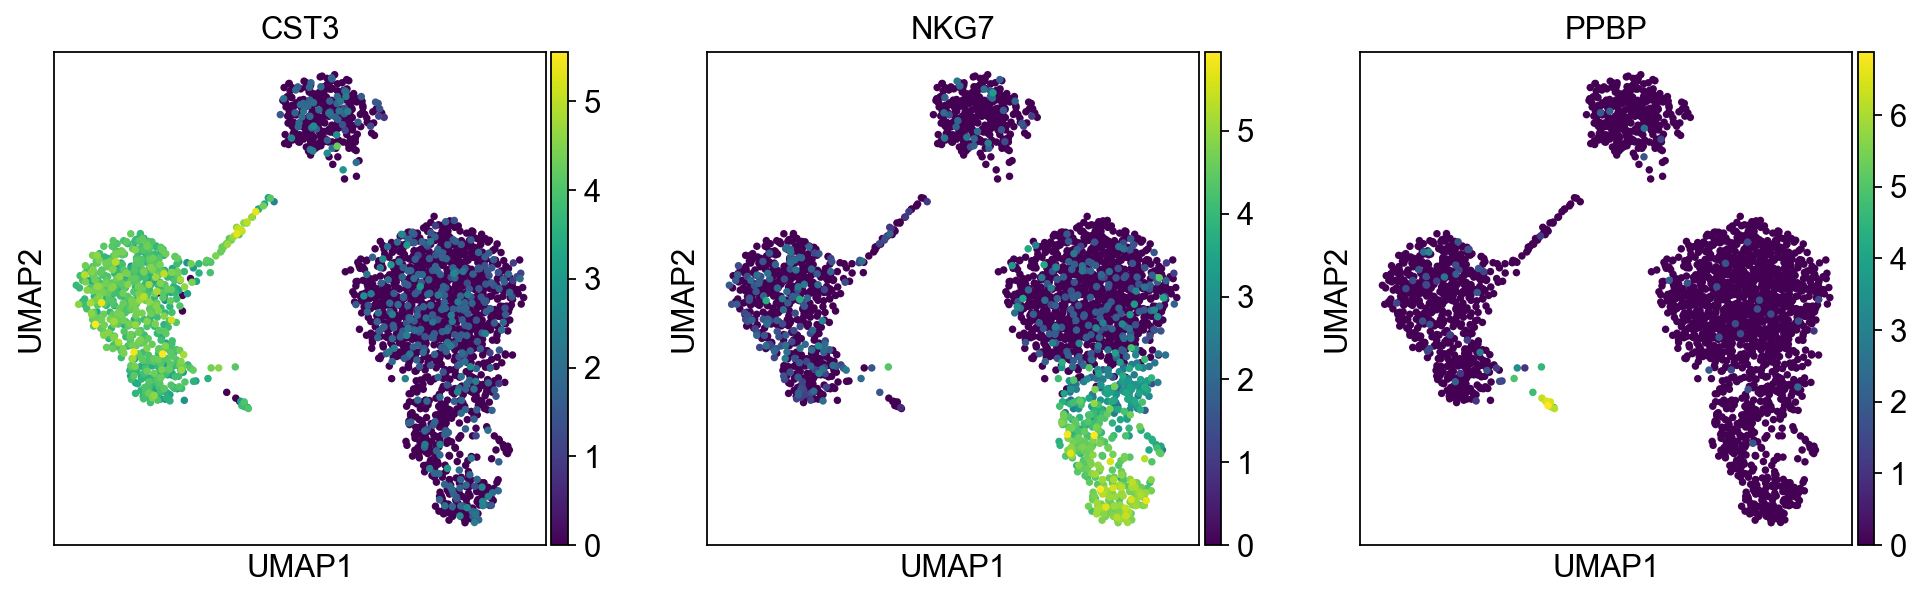

In [64]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP']) # Looking at the presence of various genes to see how well UMAP preserves global structure - it does well

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

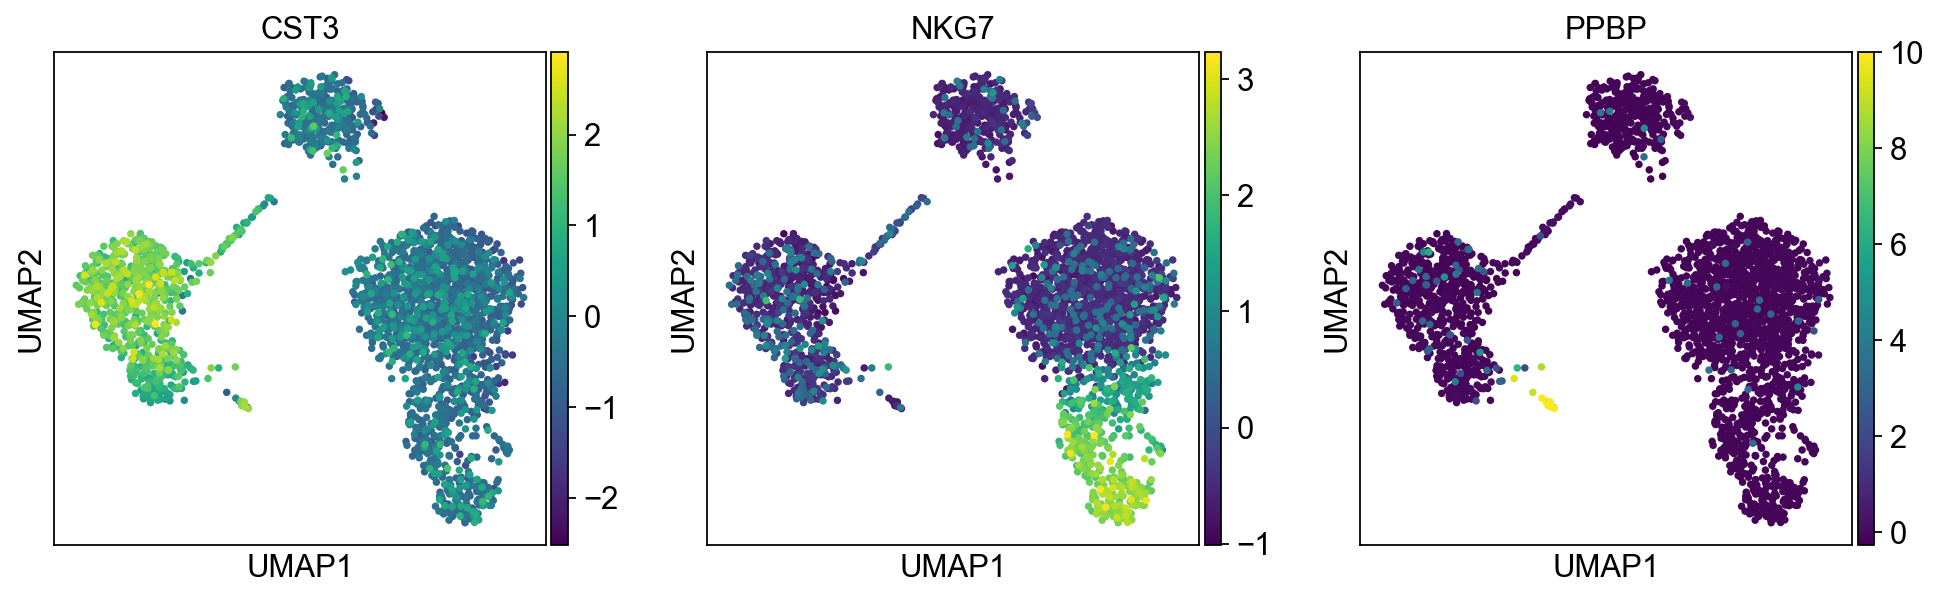

In [65]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False) # Looks now at the scaled and corrected for (regressed out) data - can't tell a large difference

## Clustering the neighborhood graph

As with Seurat and many other frameworks, we recommend the Leiden graph-clustering method (community detection based on optimizing modularity) by [Traag *et al.* (2018)](https://scanpy.readthedocs.io/en/latest/references.html#traag18). Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [66]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [67]:
sc.tl.leiden(adata) # Why does it require sc.pp.neighbors to be run first? - I guess it needs the connectivities/distance matrix

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [68]:
adata # Added labels for which leiden cluster each obs is in

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

Plot the clusters, which agree quite well with the result of Seurat.

/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


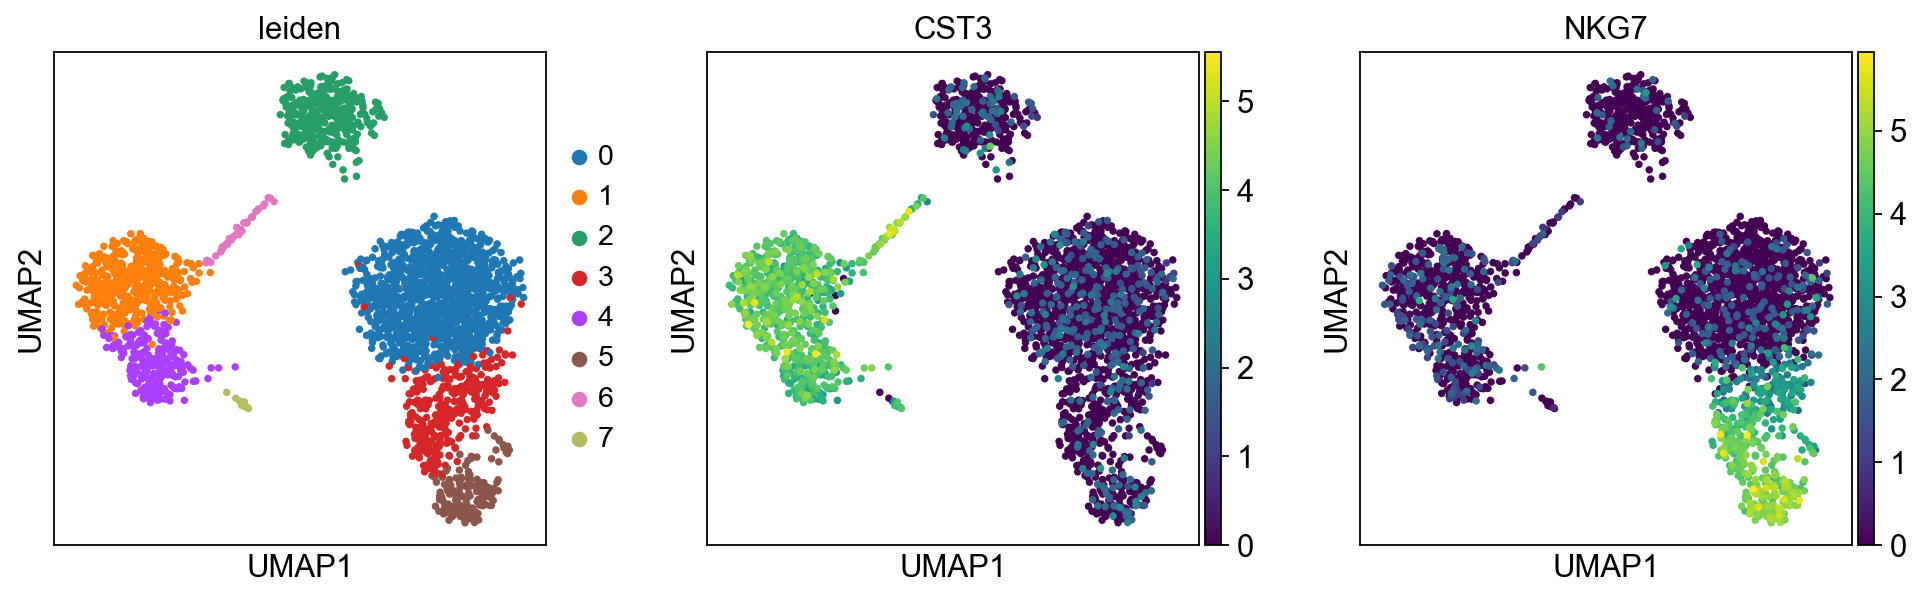

In [69]:
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

Save the result.

In [70]:
adata.write(results_file)

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


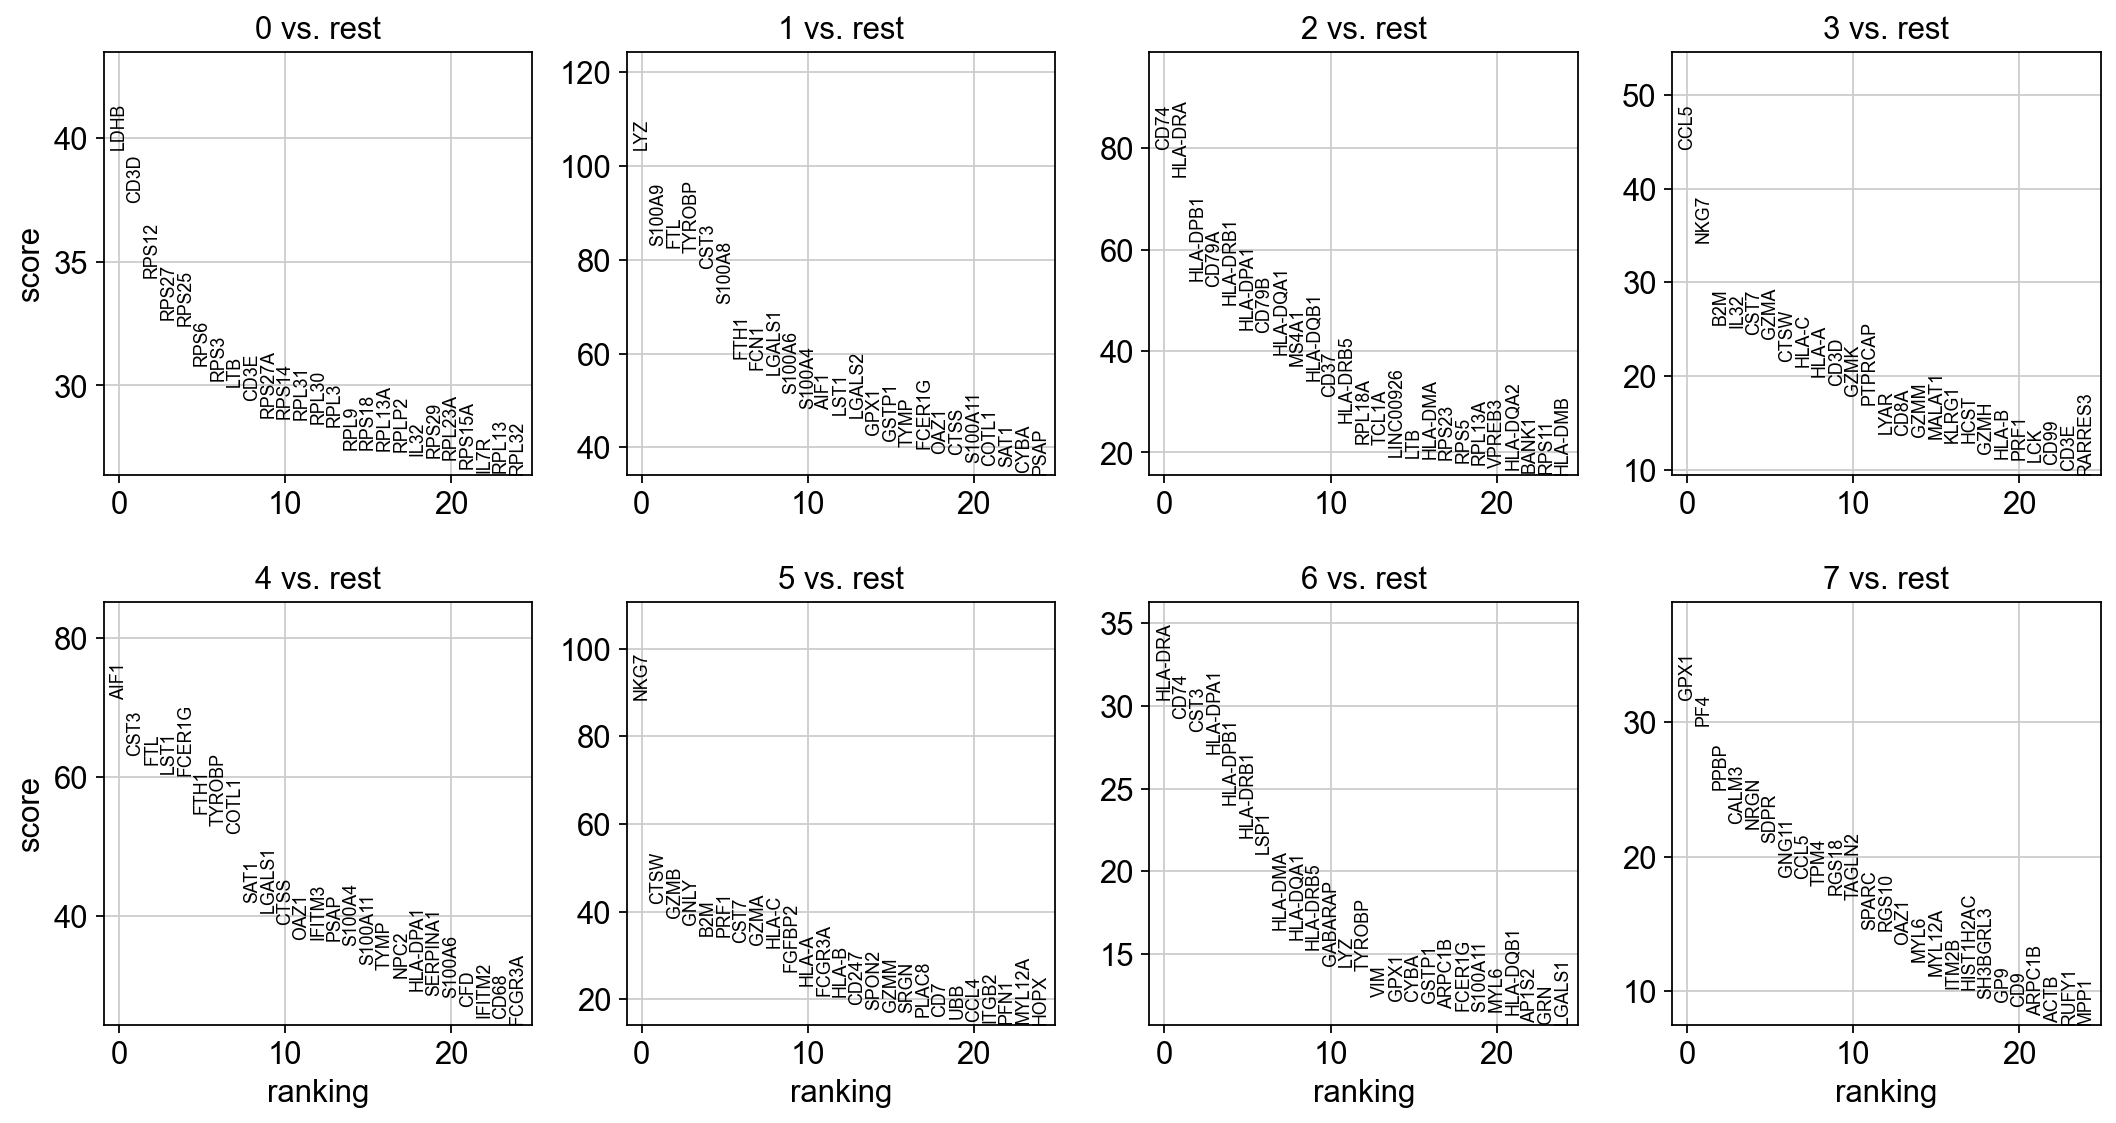

In [71]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test') # Looking at which genes characterize groups vs. the rest the best - looking at the obs leiden variable for the groups
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [73]:
adata # note the leiden, leiden_colors, and rank_genes_gruops have been added to uns - keeping track of the various processes that have transformed the data

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [72]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:06)


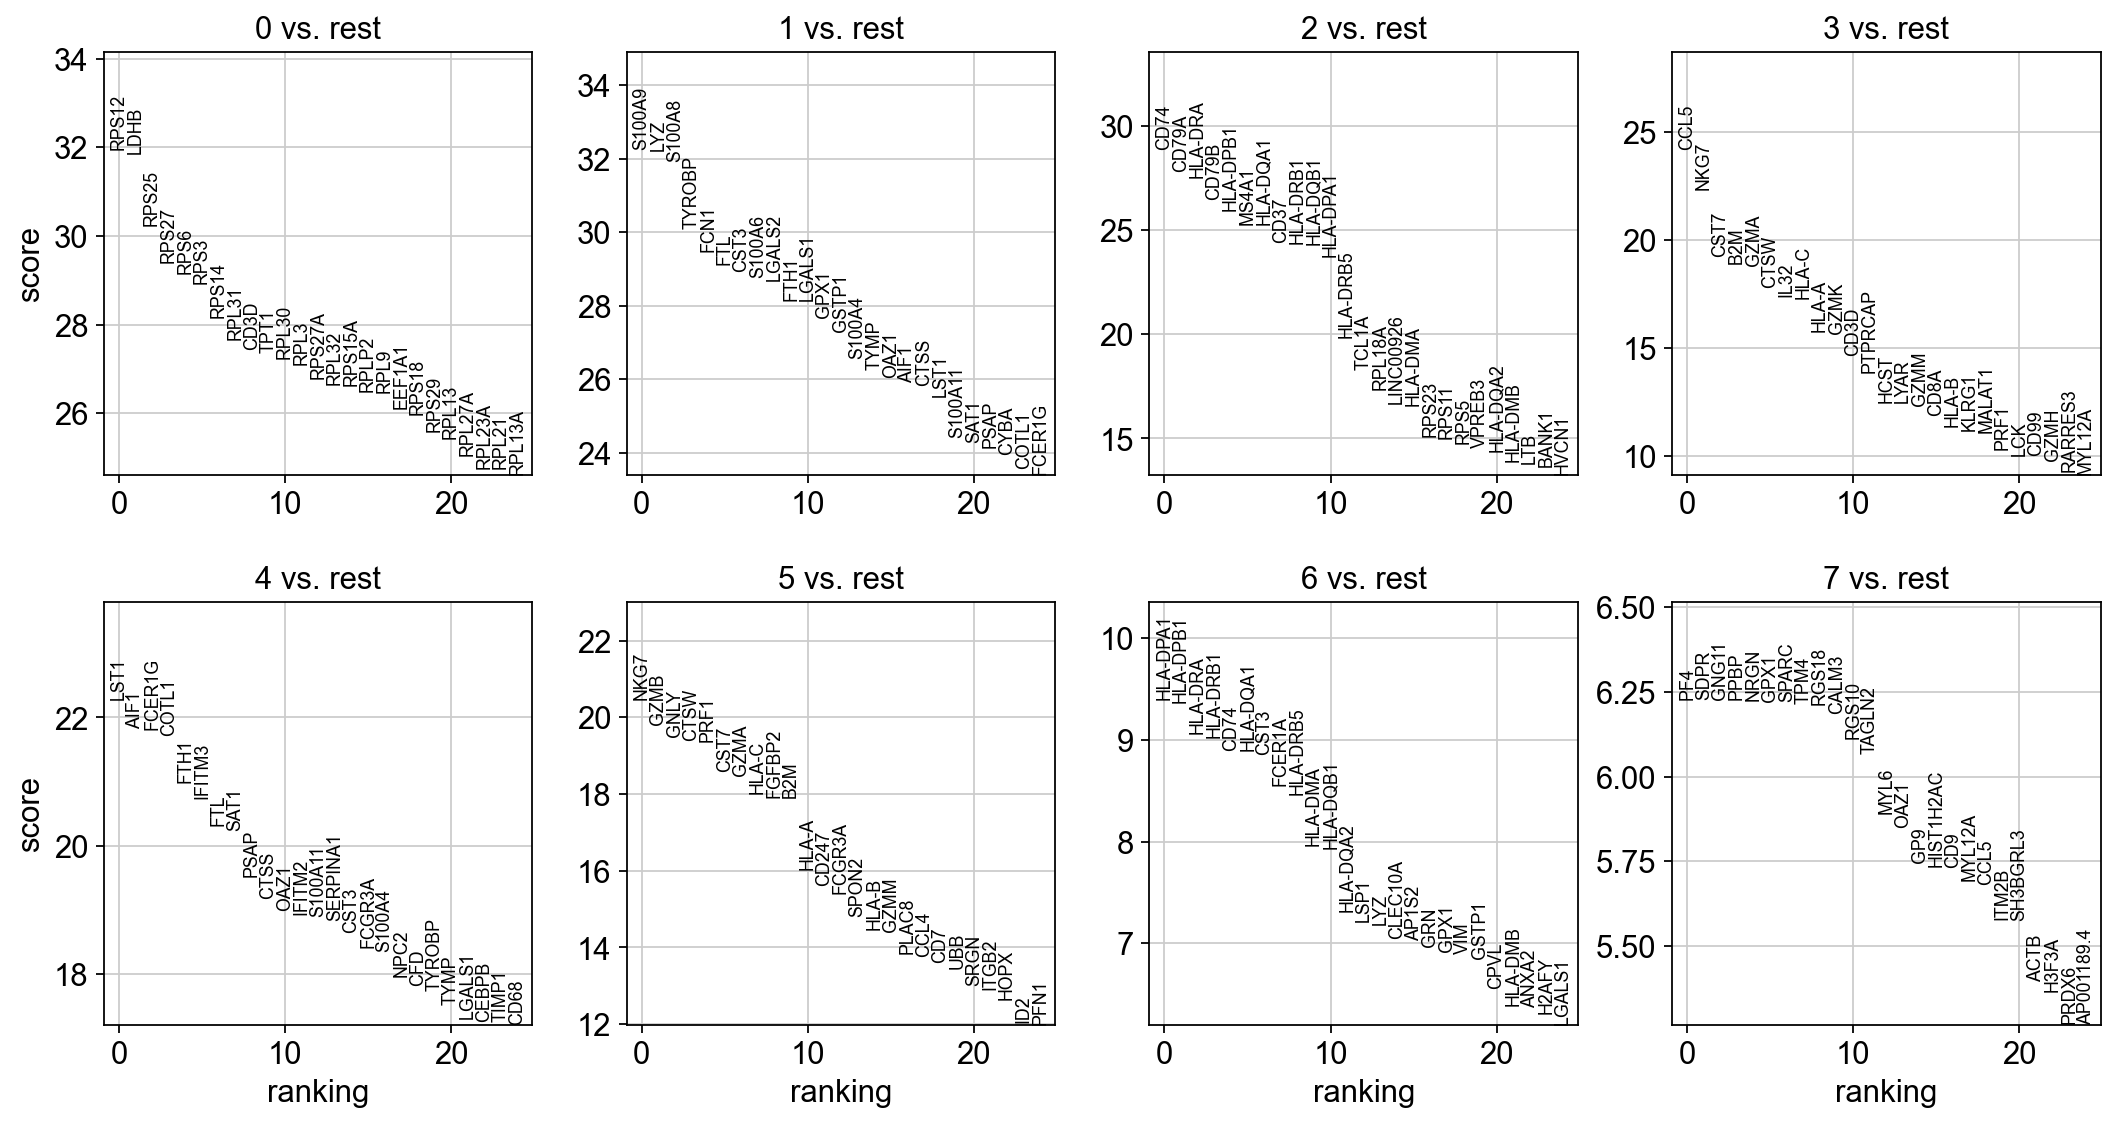

In [74]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # Yet another method to find the genes that define clusters the best
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [76]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:09)


/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


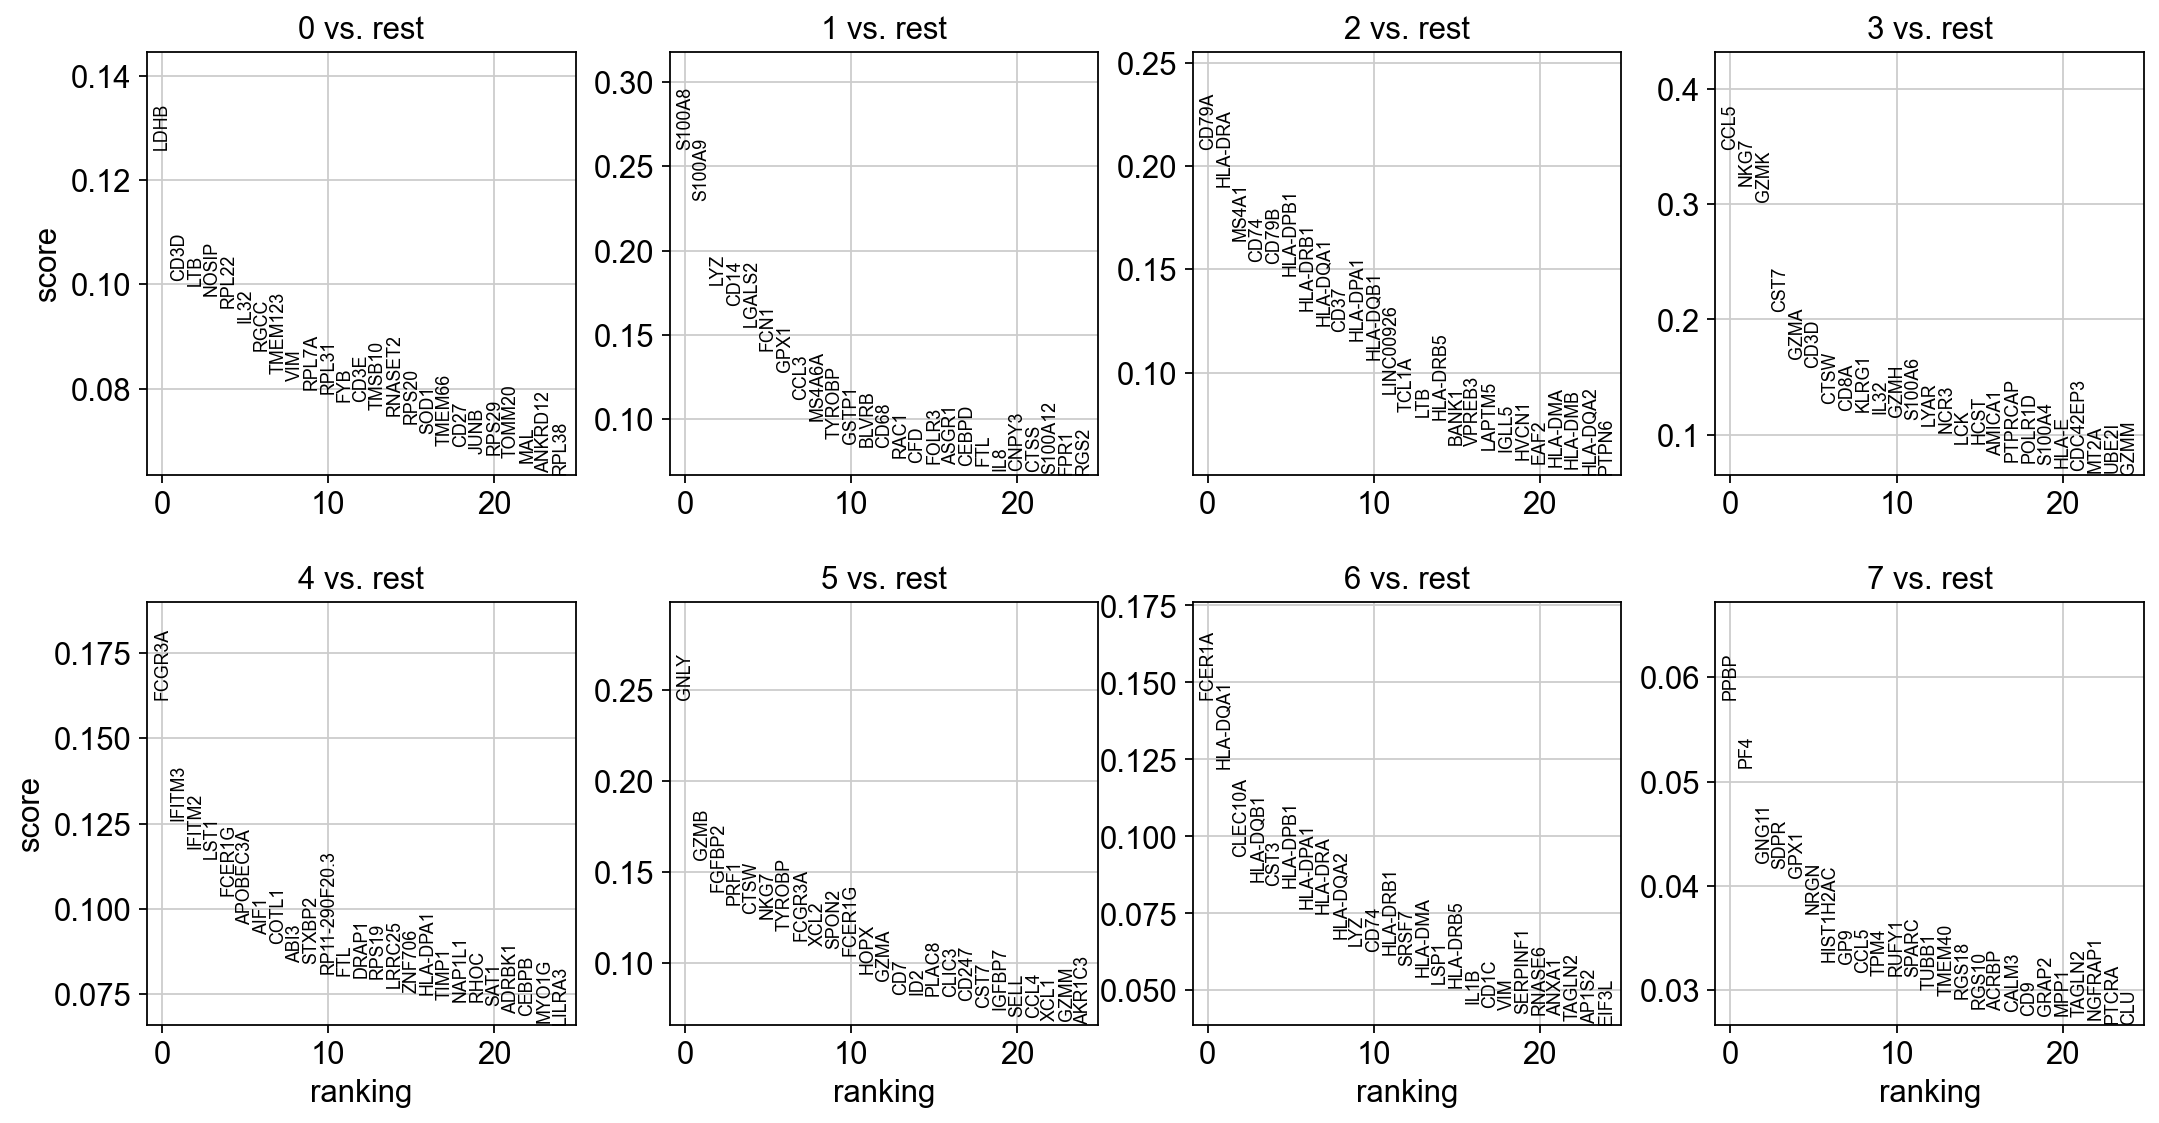

In [77]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg') # No idea what differential tests are or what multi-variate vs uni-variate means in this context - rip
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Leiden Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [78]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [79]:
adata = sc.read(results_file) # Lol seems like we prefer the Wilcoxon method

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [80]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5) # We see some of the marker genes showing up in this approach

0       1         2     3       4     5         6      7
0  RPS12  S100A9      CD74  CCL5    LST1  NKG7  HLA-DPA1    PF4
1   LDHB     LYZ     CD79A  NKG7    AIF1  GZMB  HLA-DPB1   SDPR
2  RPS25  S100A8   HLA-DRA  CST7  FCER1G  GNLY   HLA-DRA  GNG11
3  RPS27  TYROBP     CD79B   B2M   COTL1  CTSW  HLA-DRB1   PPBP
4   RPS6    FCN1  HLA-DPB1  GZMA    FTH1  PRF1      CD74   NRGN

Get a table with the scores and groups.

In [86]:
result = adata.uns['rank_genes_groups']
print(result['names'].dtype.names) # Interesting how the dtype works for this data
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

('0', '1', '2', '3', '4', '5', '6', '7')


0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  4.804248e-224  S100A9  3.165481e-228      CD74  2.487145e-183  CCL5   
1   LDHB  7.230582e-223     LYZ  1.222909e-227     CD79A  1.679730e-170  NKG7   
2  RPS25  7.300963e-201  S100A8  1.691910e-223   HLA-DRA  6.949695e-167  CST7   
3  RPS27  6.202805e-190  TYROBP  6.141017e-199     CD79B  2.569135e-154   B2M   
4   RPS6  5.493654e-187    FCN1  7.968489e-191  HLA-DPB1  3.580735e-148  GZMA   

             3_p     4_n            4_p   5_n           5_p       6_n  \
0  3.292724e-129    LST1  5.228538e-110  NKG7  3.591782e-93  HLA-DPA1   
1  1.518345e-110    AIF1  1.332400e-105  GZMB  2.033412e-87  HLA-DPB1   
2   2.707170e-82  FCER1G  1.959721e-105  GNLY  8.130223e-85   HLA-DRA   
3   1.298421e-79   COTL1  1.306716e-104  CTSW  6.944632e-84  HLA-DRB1   
4   7.536355e-79    FTH1   9.858035e-98  PRF1  1.621421e-83      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  4.722886e-10  
1  7.591860e-21   SDPR  4.733899e-10  
2  1.306768e-19  GNG11  4.733899e-10  
3  1.865104e-19   PPBP  4.744938e-10  
4  5.853161e-19   NRGN  4.800511e-10

Compare to a single cluster: 

In [94]:
# Set the base for log1p to e
adata.uns['log1p']['base'] = np.e

ranking genes


    finished (0:00:03)


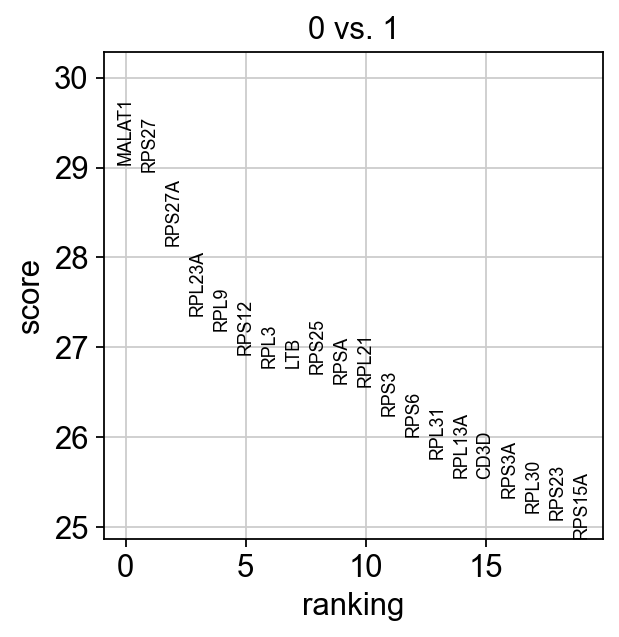

In [95]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)
# Strange how MALAT1 is coming up here

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


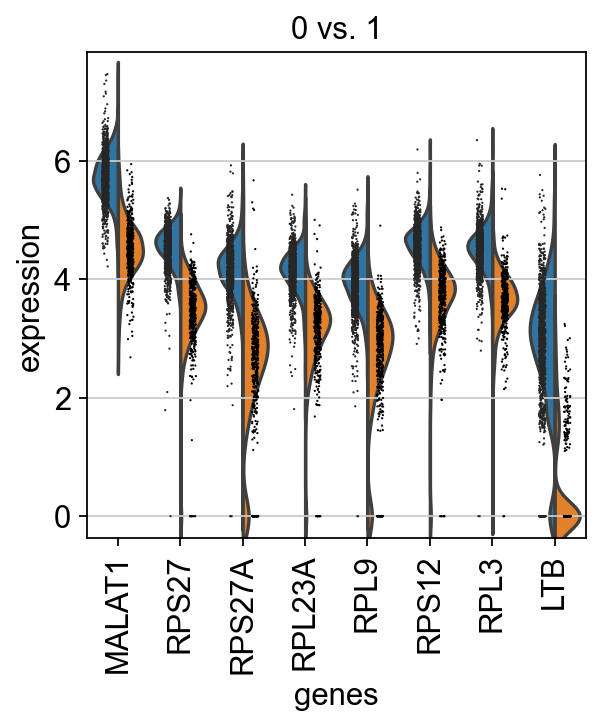

In [96]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8) # Blue is 0, orange is 1, comparing the expression of the genes in group 0 vs group 1

Reload the object with the computed differential expression (i.e. DE via a comparison with the rest of the groups):

In [97]:
adata = sc.read(results_file)

/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:black'` for same effect.
  warnings.warn(msg, FutureWarning)


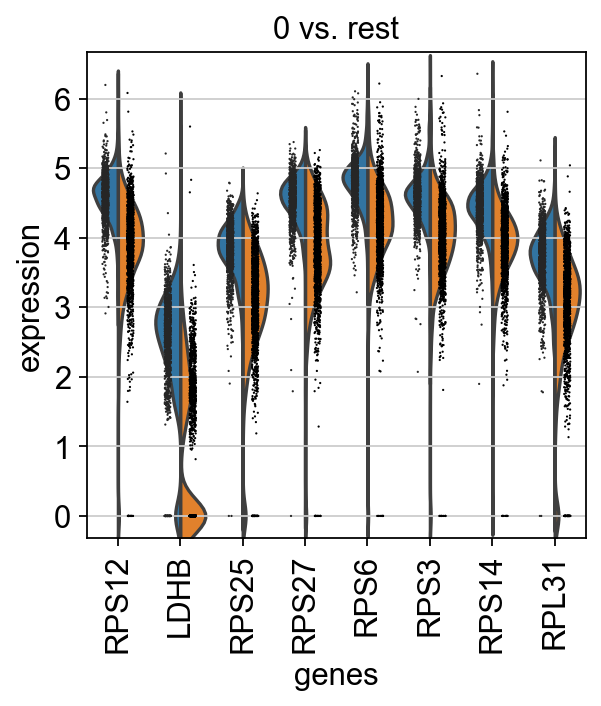

In [98]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

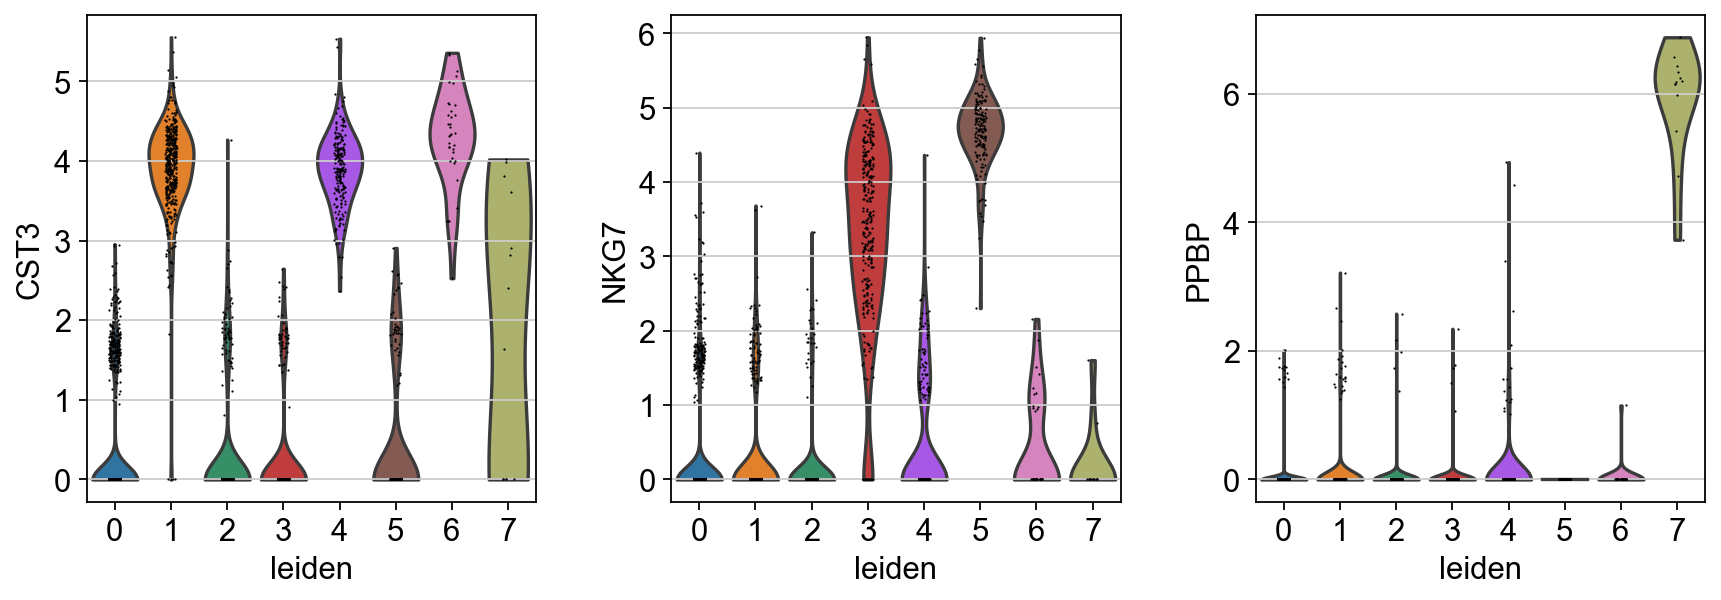

In [99]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

Actually mark the cell types.

In [100]:
# YAY! No more 0-7, but actual names - still, must say its cool that the clusters actually correspond to cell types
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

In [103]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [106]:
print(adata.obs['leiden'].cat.categories) # Note how the categories have been renamed
adata.obs['leiden']


Index(['CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes',
       'Dendritic', 'Megakaryocytes'],
      dtype='object')


AAACATACAACCAC-1               CD4 T
AAACATTGAGCTAC-1                   B
AAACATTGATCAGC-1               CD4 T
AAACCGTGCTTCCG-1                  NK
AAACCGTGTATGCG-1    FCGR3A Monocytes
                          ...       
TTTCGAACTCTCAT-1      CD14 Monocytes
TTTCTACTGAGGCA-1                   B
TTTCTACTTCCTCG-1                   B
TTTGCATGAGAGGC-1                   B
TTTGCATGCCTCAC-1               CD4 T
Name: leiden, Length: 2638, dtype: category
Categories (8, object): ['CD4 T', 'CD14 Monocytes', 'B', 'CD8 T', 'NK', 'FCGR3A Monocytes', 'Dendritic', 'Megakaryocytes']

/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


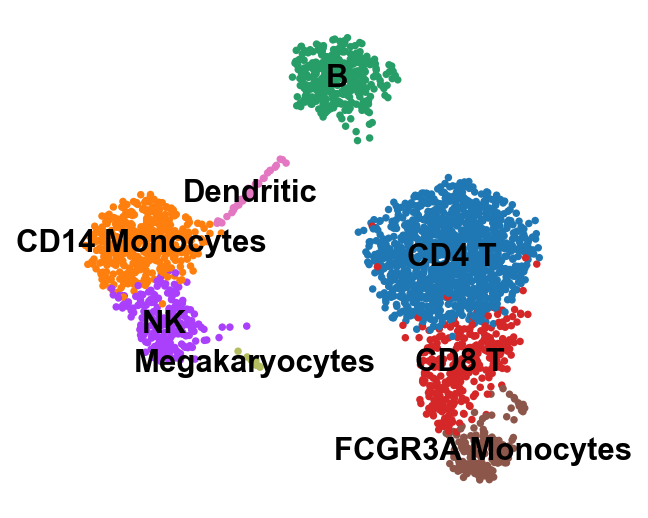

In [107]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

/Users/pranavpabba/miniconda3/envs/scanpy/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


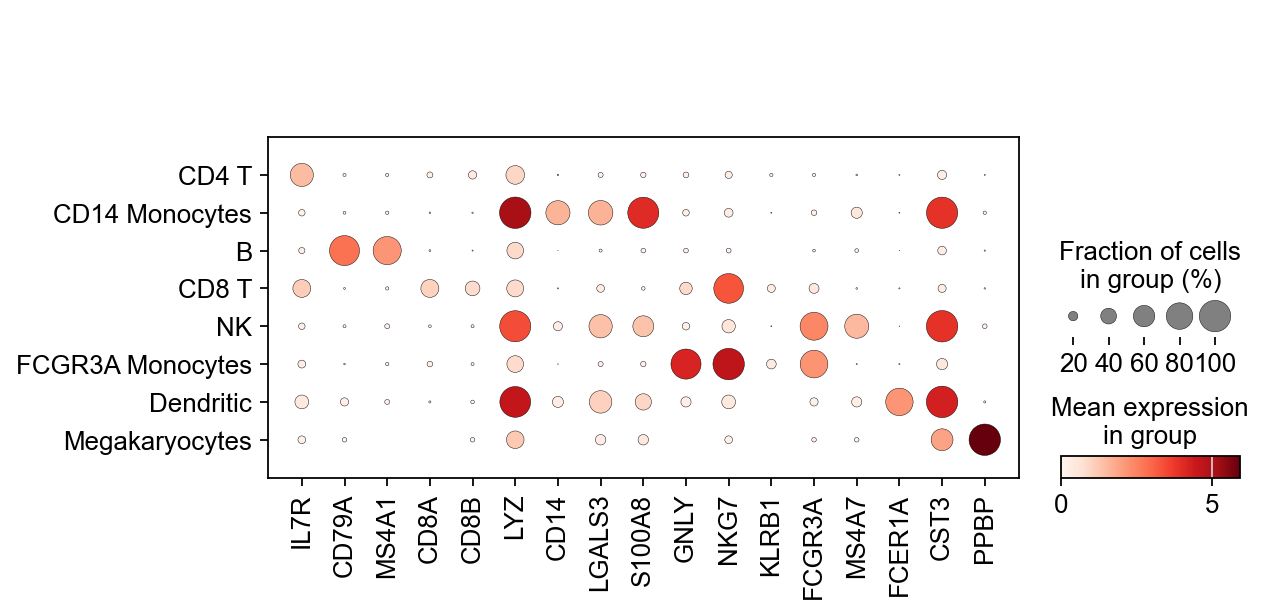

In [108]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden') # You can tell all marker genes are pretty relevant

There is also a very compact violin plot.

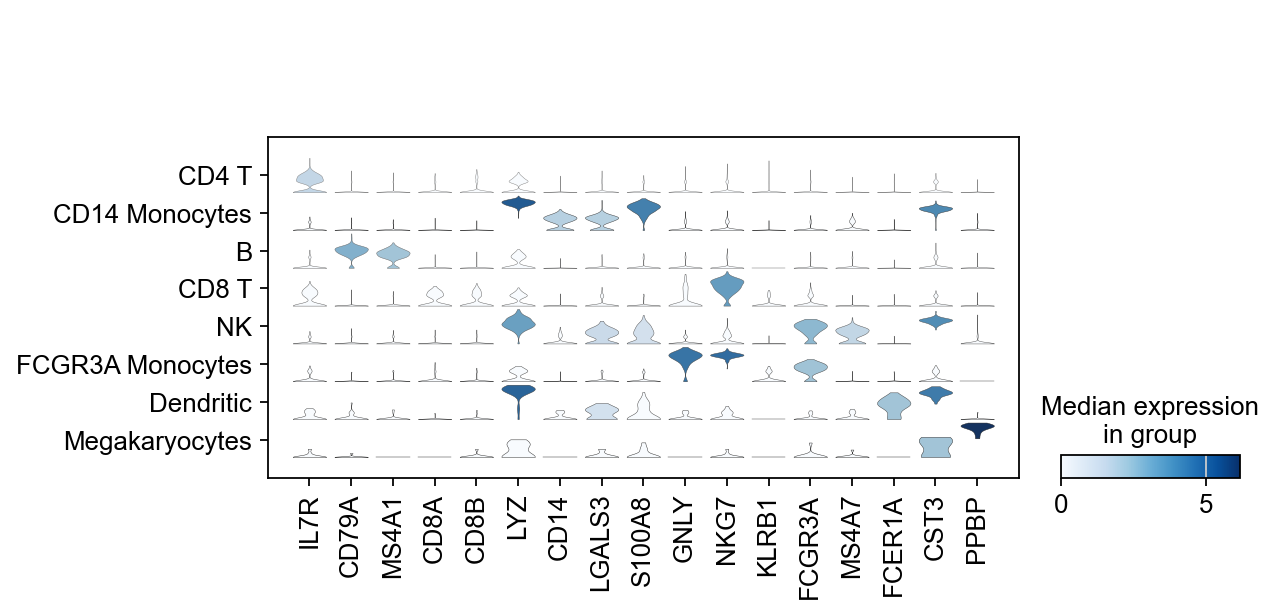

In [109]:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90) # Looks real goofy

During the course of this analysis, the AnnData accumlated the following annotations.

In [110]:
adata # Dang that's a lot

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [111]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
# huh, didn't know there was that much that went into compression choices

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations in `adata.raw`.

In [112]:
adata.raw.to_adata().write('./write/pbmc3k_withoutX.h5ad')

If you want to export to "csv", you have the following options:

In [55]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )